<a href="https://colab.research.google.com/github/SamuelaAnastasi/SPAIC_Project_TShirt/blob/master/SPAIC_ProjectTShirt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [0]:
# get the features portion 
vgg = models.vgg19(pretrained=True).features

# freeze VGG parameters 
for param in vgg.parameters():
    param.requires_grad_(False)

In [0]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:

def load_image(img_path, max_size=400, shape=None):
  
    image = Image.open(img_path).convert('RGB')
        
    # resze large large images
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
# load in content and style image
content = load_image('/gdrive/My Drive/Colab Notebooks/style_transfer/content/draw_skull_front.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/gdrive/My Drive/Colab Notebooks/style_transfer/style/pumkin.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# helper function to convert img from tensor to NumPy array
def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

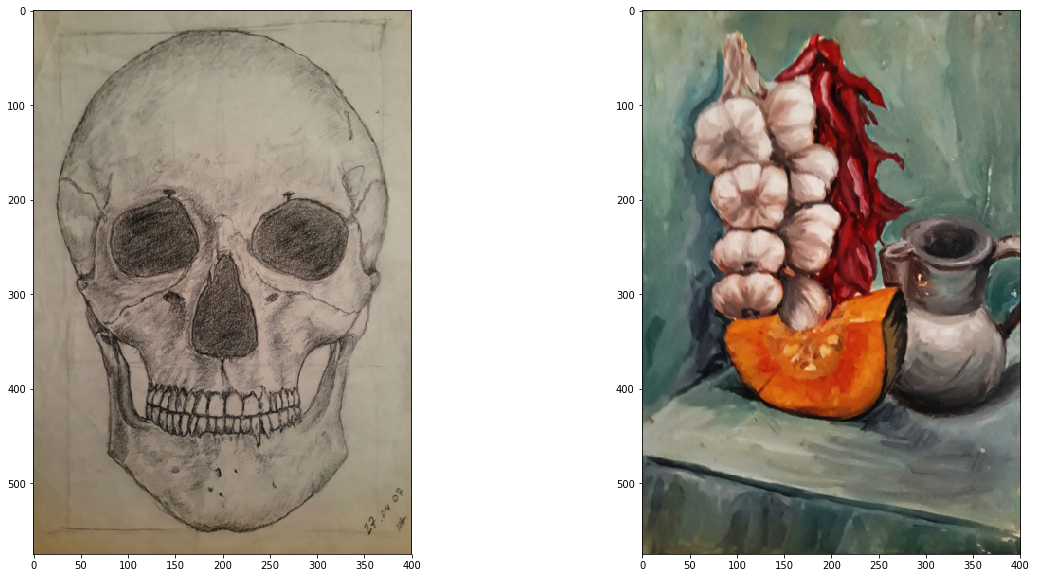

In [0]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers=None):    
    
    ## Style layers and content layers from vgg
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
# Calculate the Gram Matrix of a given tensor
def gram_matrix(tensor):
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram


In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a target image and prep it for change
target = content.clone().requires_grad_(True).to(device)

In [0]:
# weights for each style layer 
style_weights = {'conv1_1': 0.7,
                 'conv2_1': 0.6,
                 'conv3_1': 0.3,
                 'conv4_1': 0.2,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  2361303.5


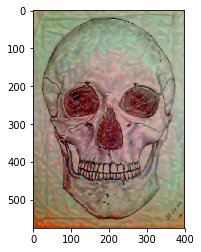

Total loss:  589472.4375


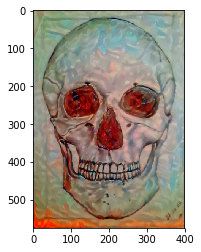

Total loss:  389270.90625


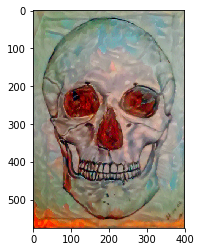

Total loss:  290665.90625


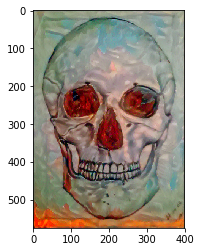

Total loss:  224684.125


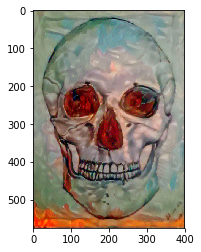

In [0]:

show_every = 400

optimizer = optim.Adam([target], lr=0.005)
steps = 2000  

for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
      
    style_loss = 0
    for layer in style_weights:
      
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

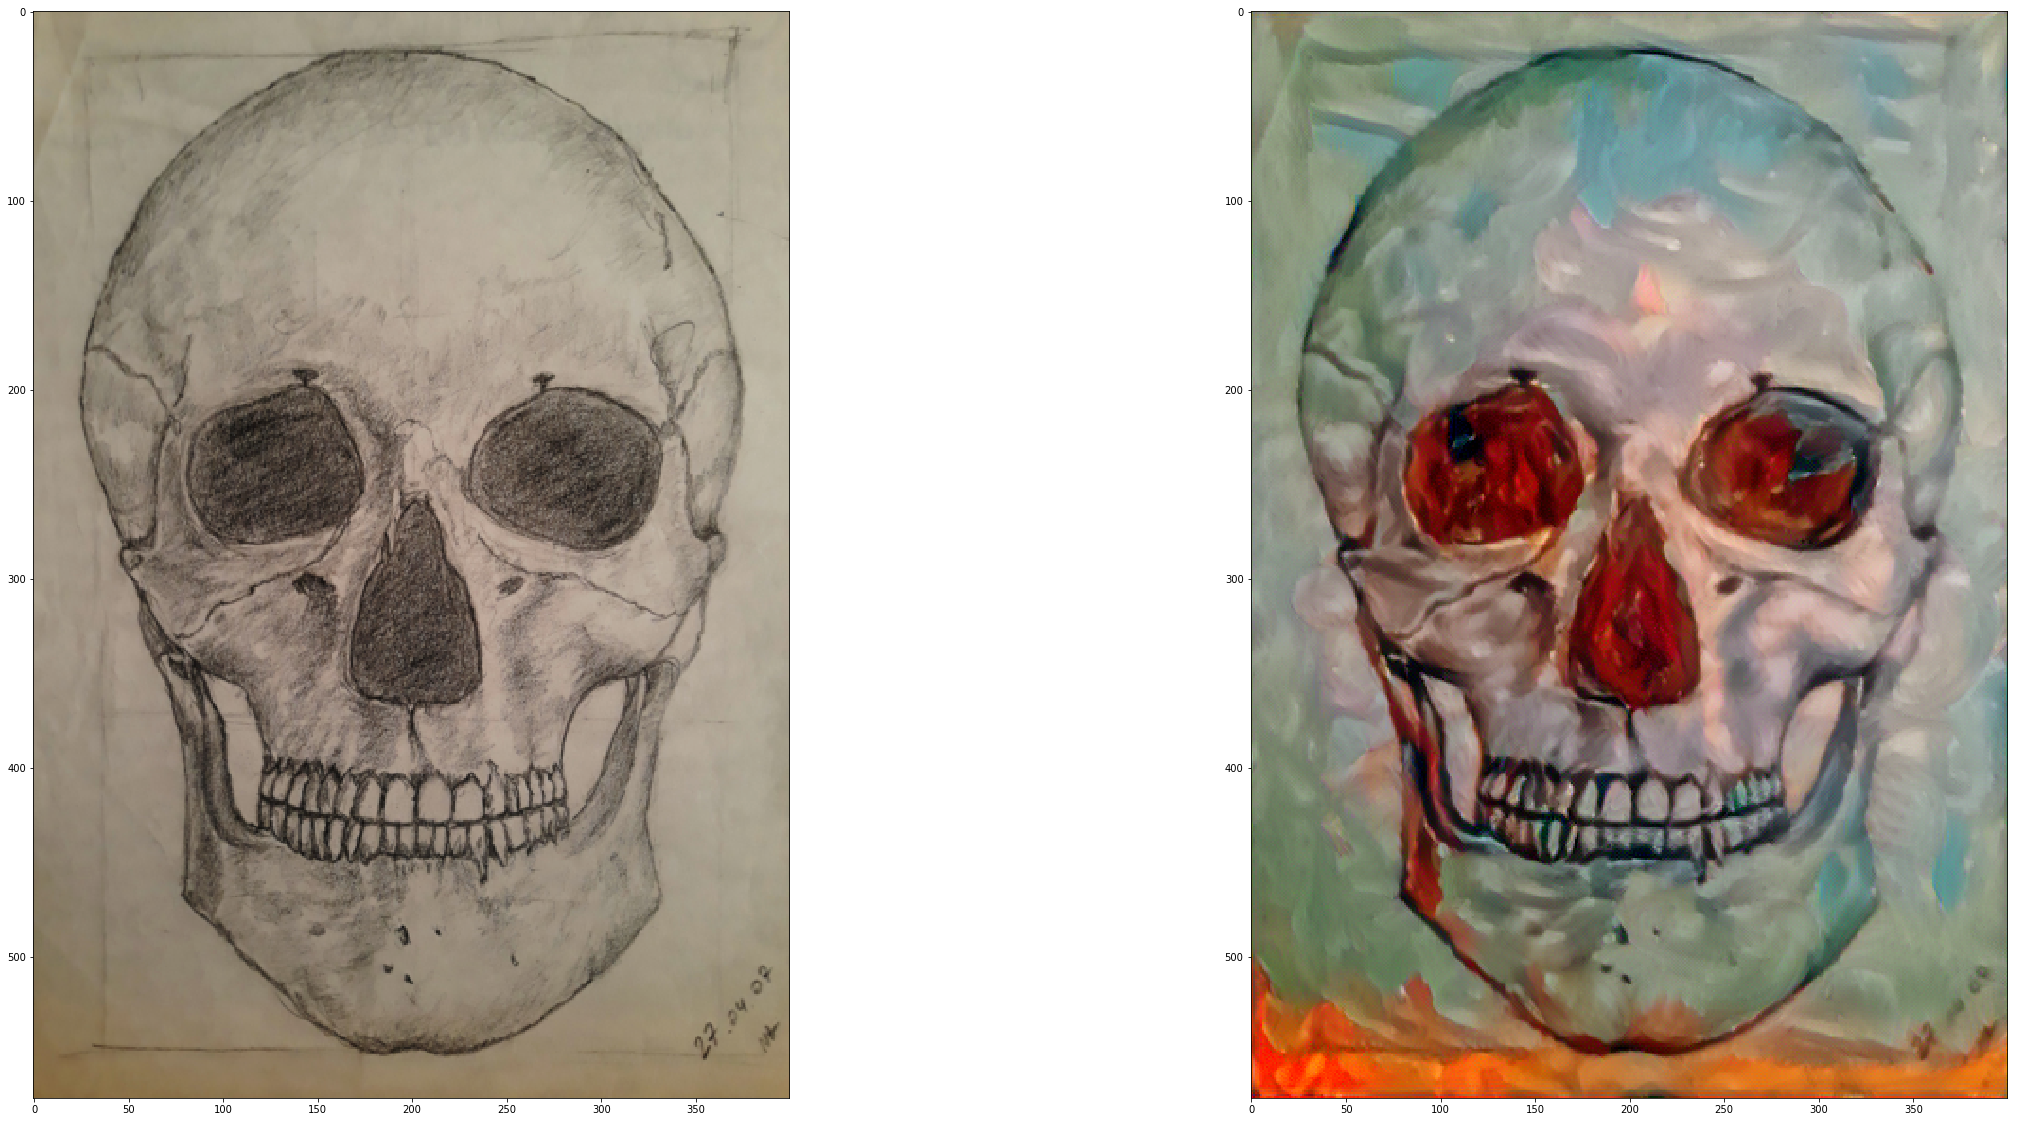

In [0]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))